In [155]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from cesium import featurize
import sqlite3
from astropy.stats import sigma_clip as sc
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as GridSpec
import glob

%matplotlib notebook

# AAM efforts

Here I am going to attempt to improve the uncertainty measurements and create a nice looking plot for our Zooniverse effort.

In [2]:
def strateva(mag, a = 0.027665,
             b = 1.285193044293278e-09,
             c = 1.0999892234090642e-19):
    return a + b*10**(0.4*mag) + c*10**(0.8*mag)

In [3]:
def lc_breaks(time, break_width=45):
    breaks = np.where(np.diff(time[np.argsort(time)]) > break_width)
    return breaks

In [190]:
def aam_plot(time, mag, mag_unc, 
             period=1, ptf_filt=2):
    """Plot a light curve suitable for Zooniverse classification
    """

    color_dict = {1: "LightSeaGreen",
                  2: "Crimson"}

    model_unc = strateva(mag)
    mean_mag = np.mean(mag)
    
    obs_breaks = lc_breaks(time)[0] + 1
    seasons = len(obs_breaks) + 1
    season_dict = {}
    total_obs_duration = 0
    for season_num in range(seasons):
        if season_num == 0:
            season = time[np.argsort(time)][0:obs_breaks[season_num]]
        elif season_num == seasons - 1:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:]
        else:
            season = time[np.argsort(time)][obs_breaks[season_num-1]:obs_breaks[season_num]]

        season_dict["start{:d}".format(season_num)] = min(season)
        season_dict["end{:d}".format(season_num)] = max(season)
        season_dict["length{:d}".format(season_num)] = np.round(np.ptp(season)) + 2
        total_obs_duration += season_dict["length{:d}".format(season_num)]
    

    
    ###### FIGURE #######    
    plot_gap = np.round(0.01*total_obs_duration/(1 - 0.01*len(obs_breaks))).astype(int)

    fig = plt.figure()

    gs = GridSpec.GridSpec(4, int(total_obs_duration) + len(obs_breaks)*plot_gap)


    amplitude = np.ptp(mean_mag - mag)
    ymin = min(mean_mag - mag) - 0.05*amplitude
    ymax = max(mean_mag - mag) + 0.05*amplitude
    if amplitude > 0.5:
        ymajor = np.round(amplitude)/4
        yminor = np.round(amplitude)/20
    else:
        ymajor = 0.1
        yminor = 0.02

    for season_num in range(seasons):
        obs_length = season_dict["length{:d}".format(season_num)]
        obs_start = season_dict["start{:d}".format(season_num)]
        obs_end = season_dict["end{:d}".format(season_num)]

        if season_num == 0:
            ax_start = 0
            ax_end = int(obs_length)
        else:
            ax_start = ax_end + plot_gap
            ax_end = ax_start + int(obs_length)
        ax = plt.subplot(gs[0, ax_start:ax_end])

        obs_this_season = np.logical_and(time >= obs_start,
                                         time <= obs_end)

        ax.errorbar(time[obs_this_season] - 54900.5, 
                     mean_mag - mag[obs_this_season], 
                     yerr=model_unc[obs_this_season], 
                     fmt="o", ms=4, mfc=color_dict[ptf_filt], 
                     ecolor=color_dict[ptf_filt], elinewidth=0.5,
                     mec="0.2", mew=0.2)
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(obs_start - 1 - 54900.5, obs_end + 1 - 54900.5)
        ax.tick_params(which="both", top=True, right=False,
                       labelbottom=False, labeltop=True,
                       labelsize=10)
        ax.tick_params(axis="x", labelrotation=25, 
                       labelsize=8, length=5, pad=0)
        
        if obs_length < 10:
            tick_val = np.around(np.floor(obs_start) + np.ceil(obs_length/2) - 54900.5, decimals=0)
            ax.set_xticks([tick_val])
        elif 10 < obs_length < 50:
            tick_val = np.around(obs_start + np.ceil(obs_length/2) - 54900.5, decimals=-1)
            ax.set_xticks([tick_val])
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        elif 50 < obs_length < 200:
            ax.xaxis.set_major_locator(MultipleLocator(50))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        if 200 < obs_length:
            ax.xaxis.set_major_locator(MultipleLocator(100))
            ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), 
                           ha='left')

        
        if season_num == 0:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.set_ylabel(r"$\Delta \, \mathrm{mag}$")

        elif season_num == seasons-1:
            ax.yaxis.set_major_locator(MultipleLocator(ymajor))
            ax.yaxis.set_minor_locator(MultipleLocator(yminor))
            ax.tick_params(which="both", axis="y", right=True,
                           left=False, labelleft=False)            
        else:
            ax.set_yticks([])
            ax.set_yticks([], minor=True)

    ax_phase = plt.subplot(gs[1:, :])
    for repeat in [-1, 0, 1]:
        ax_phase.errorbar((time/period) % 1 + repeat, 
                          mean_mag - mag, 
                          yerr=model_unc, 
                          fmt="o", ms=9, mfc=color_dict[ptf_filt], 
                          ecolor=color_dict[ptf_filt], elinewidth=0.5,
                          mec="0.2", mew=0.4, alpha=0.95)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_ylabel(r"$\Delta \, \mathrm{mag}$")

    ax_phase.axvline(x=0, ls='--', color='0.8', lw=1)
    ax_phase.axvline(x=1, ls='--', color='0.8', lw=1)
    ax_phase.set_xlim(-0.2,1.2)
    ax_phase.set_ylim(ymin,ymax)
    ax_phase.yaxis.set_major_locator(MultipleLocator(ymajor))
    ax_phase.yaxis.set_minor_locator(MultipleLocator(yminor))
    ax_phase.xaxis.set_major_locator(MultipleLocator(0.2))
    ax_phase.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_phase.tick_params(which="both", top=True, right=True, labelsize=11)

    ax_phase.text(0.5, 1.43, "Time (d)", 
                  va="bottom", ha="center",
                  transform = ax_phase.transAxes)
    fig.subplots_adjust(hspace=0.2, top=0.92,right=0.96,left=0.125)

In [191]:
filename = "./test_lcs/27882110006813.ipac_tbl"
ipac_lc = Table.read(filename, format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])

reasonable = np.logical_or((mag < 10),(mag > 23))
clipped_obs = np.copy(reasonable)
clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask
cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                           mag[~clipped_obs], 
                                           mag_unc[~clipped_obs], 
                                           features_to_use=["freq1_freq", 
                                                            "amplitude", 
                                                            "freq1_amplitude1"])
period = 1/float(cs_feats["freq1_freq"][0])

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>


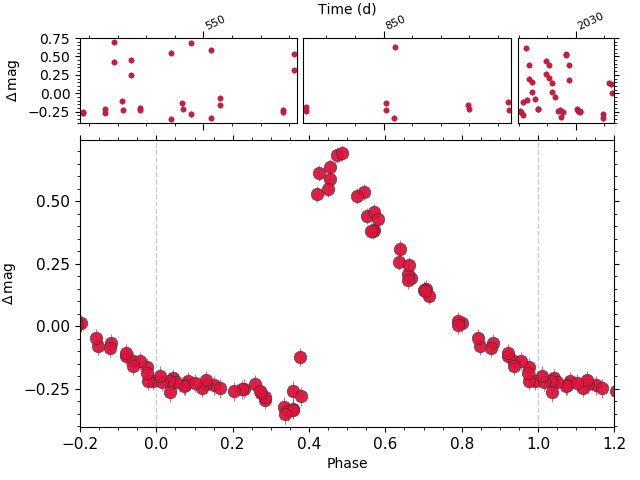

In [192]:
aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period)

In [ ]:
test_lcs = glob.glob("./test_lcs/*.ipac_tbl")

for filename in test_lcs:

    ipac_lc = Table.read(filename, format='ipac')

    hjd = np.array(ipac_lc["obsmjd"])
    mag = np.array(ipac_lc["mag_autocorr"])
    mag_unc = np.array(ipac_lc["magerr_auto"])
    
    
    reasonable = np.logical_or((mag < 10),(mag > 23))
    clipped_obs = np.copy(reasonable)
    clipped_obs[~reasonable] = sc(mag[~reasonable], sigma=5, iters=1).mask

    cs_feats = featurize.featurize_time_series(hjd[~clipped_obs], 
                                                   mag[~clipped_obs], 
                                                   mag_unc[~clipped_obs], 
                                                   features_to_use=["freq1_freq", 
                                                                    "amplitude", 
                                                                    "freq1_amplitude1"])
    period = 1/float(cs_feats["freq1_freq"][0])
    
    aam_plot(hjd[~clipped_obs], mag[~clipped_obs], mag_unc[~clipped_obs], 
         period=period)

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>

/Users/adamamiller/miniconda3/envs/NUREU17/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


<IPython.core.display.Javascript object>